In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from typing import List, Callable
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
x = 5

# DATA DOWNLOADING AND PROCESSING

In [2]:
# Extract Meta data from yfinance
GetFacebookInformation = yf.Ticker("META")
pd.DataFrame(GetFacebookInformation.info).head()
GetFacebookInformation.history(period='5y').info()

In [ ]:
# Let us get historical stock prices for Facebook 
data =  GetFacebookInformation.history(period="5y")
# selecting independent feature's data
vectors = data[['Open', 'Close', 'High', 'Low']].values.tolist()
vectors.pop()
for vector in vectors:
    vector.append(1)
# vectors now that column that correspond to intercept 
vectors[0]

[183.30551158106815,
 181.9969024658203,
 184.364385666914,
 181.15779642525757,
 1]

In [ ]:
# selecting dependent feature's data
y_vectors = data[['Open', 'Close', 'High', 'Low']].values.tolist()
y_values = [sum(y_vector) / 4 for y_vector in y_vectors]
y_values.pop(0)
len(y_values)

1258

In [ ]:
# Split data into train and test sets
split_index = int(0.8 * len(vectors))
train_vectors, test_vectors = vectors[:split_index], vectors[split_index:]
train_y_values, test_y_values = y_values[:split_index], y_values[split_index:]

# BASIC FUNCTIONS FOR ALGEBRA CALCULATION

In [ ]:
from typing import List # define vector
Vector = List[float]

In [ ]:
 #define scalar product
def dot(v, w) -> float:
    return sum(v_i * w_i for v_i, w_i in zip(v, w))

In [ ]:
# our model's prediction function
def predict(x: Vector, beta: Vector) -> float: 
    return dot(x,beta)

In [ ]:
# compute the element-wise sum for a list of vectors
# i.e: new_vector[i] = sum of all vector[i] for vector in vectors
def vector_sum(vectors: List[Vector]) -> Vector:    
    assert vectors, "No vectors provided!"
    num_elements = len(vectors[0])
    assert all(len(v) == num_elements for v in vectors), "different sizes!"
    return [sum(vector[i] for vector in vectors) for i in range(num_elements)]
    

In [ ]:
def scalar_multiply(c: float, v:Vector) ->Vector: 
    return [c *v_i for v_i in v]

In [ ]:
# compute the element-wise mean for a list of vectors
def vector_mean(vectors: List[Vector]) -> Vector: 
    n = len(vectors)
    return scalar_multiply(1/n, vector_sum(vectors))

# FUNCTION FOR CALCULATING GRADIENT DESCENT

In [ ]:
#error calculating function
def error(x: Vector, y:float, beta: Vector) ->float: 
    return predict(x,beta) -y

In [ ]:
# square of error calculating function
def squared_error(x:Vector, y: float, beta: Vector) -> float: 
    return error(x,y,beta) **2

In [ ]:
# gradient of each x vector in SSE function
def sqerror_gradient(x: Vector, y: float, beta:Vector) -> Vector:
    err = error(x,y,beta)
    return [2*err*x_i for x_i in x]

### CALCULATING GRADIENT STEP

In [ ]:
# return a new vector that has move in the negative gradient direction by a 'step_size' amount
def gradient_step(v: Vector, gradient: Vector, step_size: float) -> Vector:
    return [v_i - step_size * gradient_i for v_i, gradient_i in zip(v, gradient)]


In [ ]:
# return a optimize weight vector correspond to features
def least_squares_fit(xs: List[Vector], ys: List[float], learning_rate: float = 0.00000001, num_steps: int = 10000, batch_size: int = 1) -> Vector:
    guess = [0.0] * len(xs[0])
    for _ in range(num_steps):
        for start in range(0, len(xs), batch_size):
            batch_xs = xs[start:start + batch_size]
            batch_ys = ys[start:start + batch_size]
            gradient = vector_mean([sqerror_gradient(x, y, guess) for x, y in zip(batch_xs, batch_ys)])
            guess = gradient_step(guess, gradient, learning_rate)
    return guess



In [ ]:
learning_rate = 0.00000001
beta = least_squares_fit(train_vectors, train_y_values, learning_rate, 30000, 1)
print("Nghiệm tìm được bằng least_squares_fit:", beta)

Nghiệm tìm được bằng least_squares_fit: [-0.24907850398905304, 0.7088386808127399, 0.22544349038284892, 0.314801159547922, 0.0756545480566027]


In [ ]:
model = LinearRegression()
new_vectors = train_vectors
for vector in new_vectors:
    vector.pop()
model.fit(new_vectors, train_y_values)
coef = model.coef_.tolist()
coef.append(model.intercept_)
print("Hệ số của các biến:", coef)


Hệ số của các biến: [-0.26489412806554463, 0.6949658283124249, 0.18476839965680897, 0.38363938145177734, 1.0179334493052181]


# Đây là sử dụng model của sklearn để predict

In [ ]:
test = data[['Open', 'Close', 'High', 'Low']].values.tolist()
last_day_data = test[-1]
last_day_data.append(1)
y = predict(last_day_data, beta)
print("Giá cổ phiếu dự đoán ngày tiếp theo (bằng least square fit): ", y)


Giá cổ phiếu dự đoán ngày tiếp theo (bằng least square fit):  479.41896687490316


# Evaluation Matrix

In [ ]:
# Predictions using custom least squares fit
train_predictions_custom = [predict(x, beta) for x in train_vectors]
test_predictions_custom = [predict(x, beta) for x in test_vectors]

In [ ]:
# Train and predict with sklearn's LinearRegression
model = LinearRegression()
model.fit(train_vectors, train_y_values)
for test in test_vectors:
    test.pop()
train_predictions_sklearn = model.predict(new_vectors)
test_predictions_sklearn = model.predict(test_vectors)

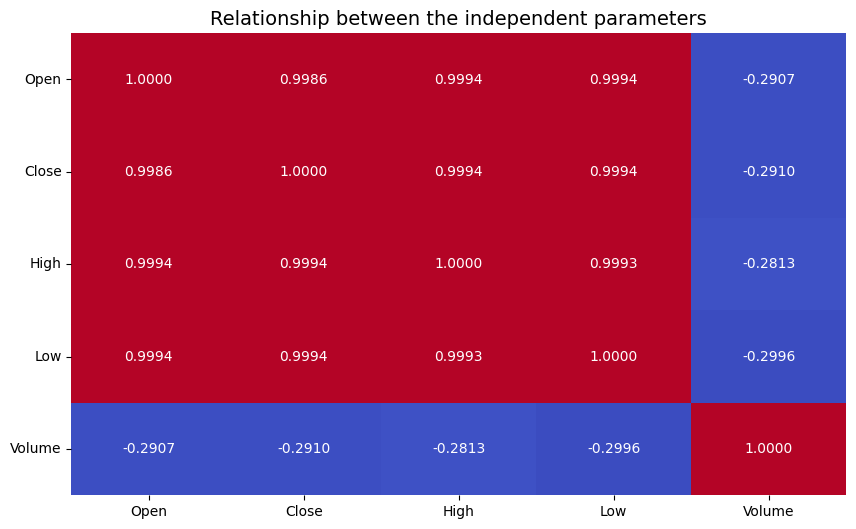

In [ ]:
# Create correlation matrix
corr_matrix = data[['Open', 'Close', 'High', 'Low','Volume']].corr()
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".4f", cmap='coolwarm', ax=ax, cbar=False, annot_kws={"size": 10})

# Set table config
ax.set_title('Relationship between the independent parameters', fontsize=14)
ax.set_xticklabels(corr_matrix.columns, rotation=0, fontsize=10)
ax.set_yticklabels(corr_matrix.columns, rotation=0, fontsize=10)

# Show table
plt.show()

In [ ]:
# Save as png file
fig.savefig('relationship_table.png', dpi=300, bbox_inches='tight')

In [ ]:
# Calculating evaluation metrics
def adjusted_r2(r2, n, p):
    """ calculate the proportion of y values explain only by relevant independent variables"""
    return 1 - (1 - r2) * ((n - 1) / (n - p - 1))

metrics = {
    "Model": [],
    "R-Squared": [],
    "Adjusted R-Squared": [],
    "Multiple R": [],
    "Standard Error": [],
    "MSE": []
}

def evaluate_model(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    adj_r2 = adjusted_r2(r2, len(y_true), len(train_vectors[0]))
    mse = mean_squared_error(y_true, y_pred)
    std_error = np.sqrt(mse)
    metrics["Model"].append(model_name)
    metrics["R-Squared"].append(r2)
    metrics["Adjusted R-Squared"].append(adj_r2)
    metrics["Multiple R"].append(np.sqrt(r2))
    metrics["Standard Error"].append(std_error)
    metrics["MSE"].append(mse)

evaluate_model(test_y_values, test_predictions_custom, "Custom Least Squares")
evaluate_model(test_y_values, test_predictions_sklearn, "Sklearn LinearRegression")

# Display evaluation metrics
evaluation_df = pd.DataFrame(metrics)
print(evaluation_df)

# Save the model
import pickle

with open('linear_regression_model.pkl', 'wb') as file:
    pickle.dump(model, file)

with open('custom_least_squares_model.pkl', 'wb') as file:
    pickle.dump(beta, file)


                      Model  R-Squared  Adjusted R-Squared  Multiple R  \
0      Custom Least Squares   0.991384            0.991245    0.995683   
1  Sklearn LinearRegression   0.991405            0.991266    0.995693   

   Standard Error        MSE  
0        7.702352  59.326230  
1        7.693209  59.185463  


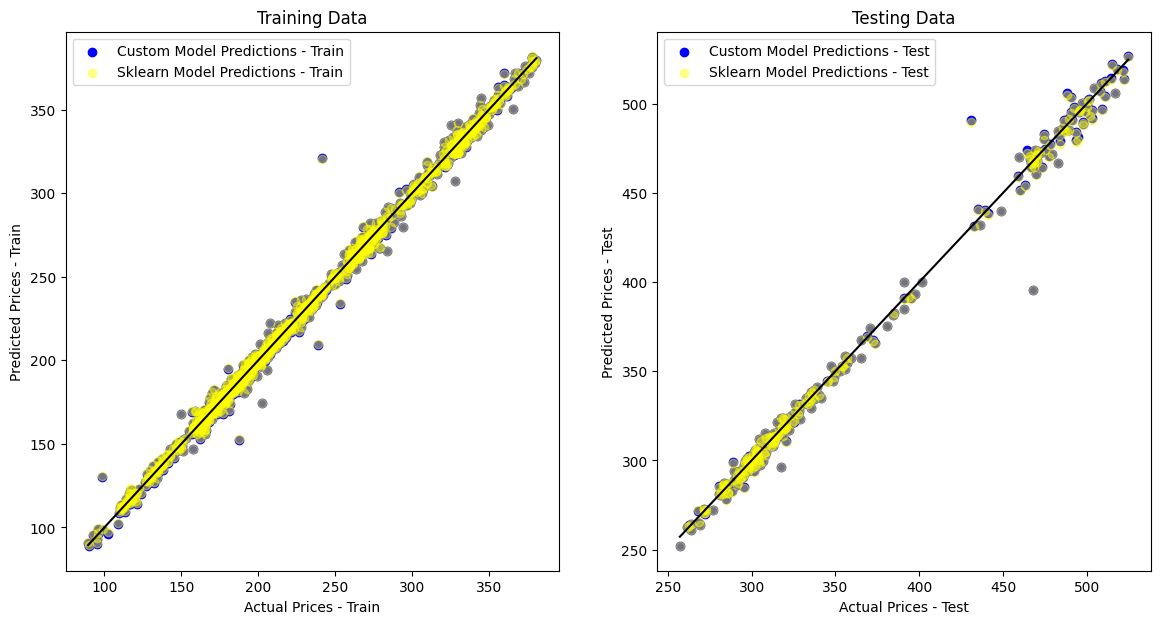

In [ ]:
# Vẽ biểu đồ scatter plot
plt.figure(figsize=(14, 7))

# Biểu đồ scatter plot cho tập train
plt.subplot(1, 2, 1)
plt.scatter(train_y_values, train_predictions_custom, label="Custom Model Predictions - Train", alpha=1,color='blue')
plt.scatter(train_y_values, train_predictions_sklearn, label="Sklearn Model Predictions - Train", alpha=0.45,color='yellow')
plt.plot([min(train_y_values), max(train_y_values)], [min(train_y_values), max(train_y_values)], color='black')
plt.xlabel('Actual Prices - Train')
plt.ylabel('Predicted Prices - Train')
plt.title('Training Data')
plt.legend()

# Biểu đồ scatter plot cho tập test
plt.subplot(1, 2, 2)
plt.scatter(test_y_values, test_predictions_custom, label="Custom Model Predictions - Test", alpha=1,color='blue')
plt.scatter(test_y_values, test_predictions_sklearn, label="Sklearn Model Predictions - Test", alpha=0.45, color='yellow')
plt.plot([min(test_y_values), max(test_y_values)], [min(test_y_values), max(test_y_values)], color='black')
plt.xlabel('Actual Prices - Test')
plt.ylabel('Predicted Prices - Test')
plt.title('Testing Data')
plt.legend()
plt.savefig('model evaluation.png',dpi=100, bbox_inches='tight')
plt.show()
